In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2025-05-11 13:21:17.015381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 13:21:17.026499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 13:21:17.029819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 13:21:17.038215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Charge npy files
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# Charge embeddings of Facenet for Train, Val and Test
path_train = '../../../../Facenet Embeddings/Train/X_train.npy'
path_val   = '../../../../Facenet Embeddings/Val/X_val.npy'
path_test  = '../../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

X = np.concatenate((X_val, X_test), axis=0)
y = np.concatenate((y_val, y_test), axis=0)

In [4]:
# Divide data in Val and test
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123, stratify=y)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((5481, 5, 128), (1721, 5, 128), (1722, 5, 128), (5481,), (1721,), (1722,))

In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 40.3014705882353,
 1: 6.40303738317757,
 2: 0.5172706681766704,
 3: 0.5302825077399381}

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, verbose=1)

# BILSTM model
def build_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # 1st BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(inputs)
    
    # 2nd BiLSTM
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    
    # Global Pooling 
    x = GlobalAveragePooling1D()(x)
    
    # Dense + Dropout
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(4, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    
    return model

# Create and train the BILSTM model
model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

I0000 00:00:1746987739.963748   35248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746987739.991813   35248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746987739.991884   35248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746987739.995558   35248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1746987739.995680   35248 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.3132 - loss: 1.2946 - val_accuracy: 0.3928 - val_loss: 1.3340 - learning_rate: 1.0000e-04
Epoch 2/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.3330 - loss: 1.3946 - val_accuracy: 0.3393 - val_loss: 1.3366 - learning_rate: 1.0000e-04
Epoch 3/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.3459 - loss: 1.3351 - val_accuracy: 0.3359 - val_loss: 1.3326 - learning_rate: 1.0000e-04
Epoch 4/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.3124 - loss: 1.4235 - val_accuracy: 0.3219 - val_loss: 1.3367 - learning_rate: 1.0000e-04
Epoch 5/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.3523 - loss: 1.3061 - val_accuracy: 0.3033 - val_loss: 1.3369 - learning_rate: 1.0000e-04
Epoch 6/1000
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.3774 - loss: 1.2862 - val_accuracy: 0.2998 - val_loss: 1.3460 - learning_rate: 1.0000e-04
Epoch 7/1000
172/172 ━━━━━━━━━━━━━

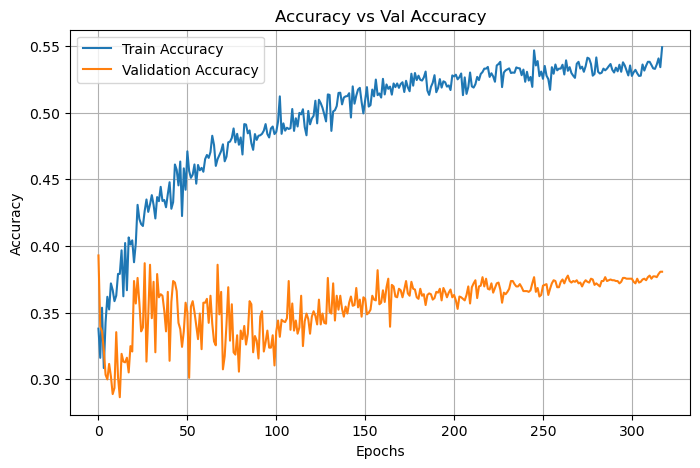

In [8]:
# Train Accuracy vs Val Accuracy 
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

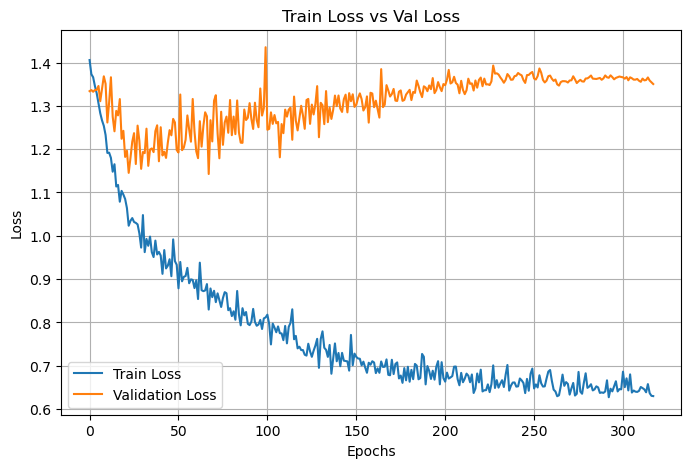

In [9]:
# Train Loss vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Train Loss vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Predictions
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


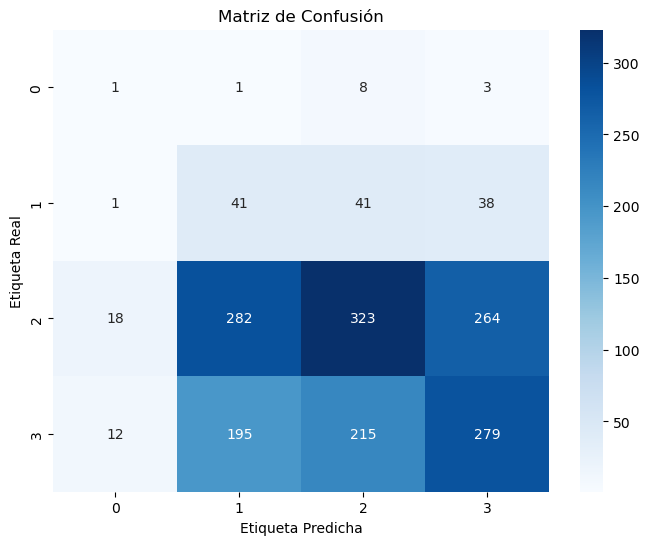

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [12]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.031     0.077     0.044        13
           1      0.079     0.339     0.128       121
           2      0.550     0.364     0.438       887
           3      0.478     0.398     0.434       701

    accuracy                          0.374      1722
   macro avg      0.285     0.294     0.261      1722
weighted avg      0.484     0.374     0.412      1722



In [13]:
# UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f'UAR: {uar_score:.4f}')

UAR: 0.2945
